## Data manipolation

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qdatoolkit as qda

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [5]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_14401/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_14401/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [95]:
list_25l.shape

(25, 117, 118)

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)
num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

In [5]:
# Iterate through each layer's smallest cluster data
data = []
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

,x,y,temp_std,layer_id
0,0,0,2.732935,1
1,2,0,2.486629,1
2,4,0,2.301647,1
3,6,0,3.156023,1
4,7,0,1.891568,1


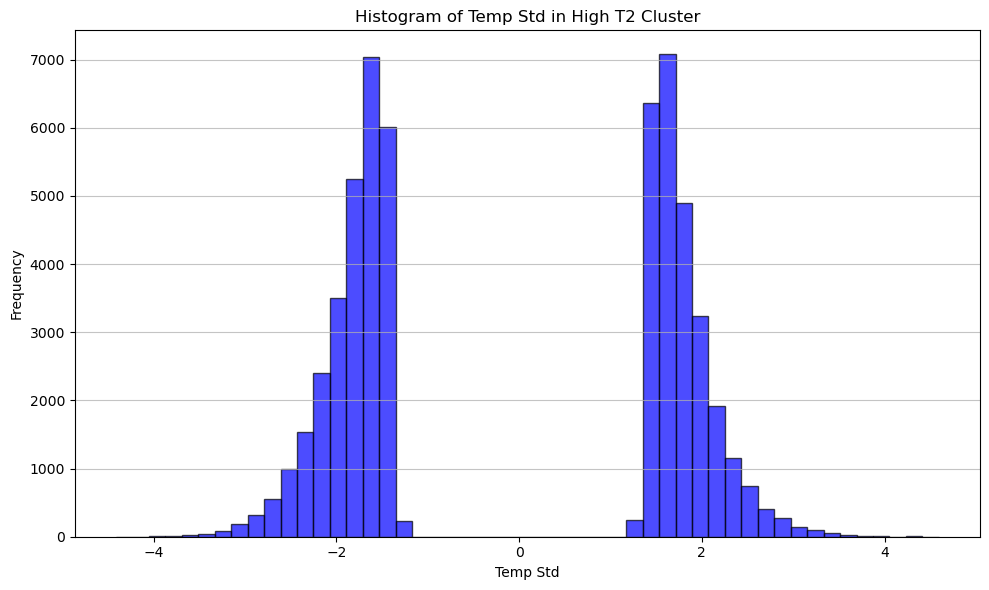

In [6]:
# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

The temperature in the high T2 cluster is bimodal, signaling cold and hot spots. We separate the data at temp_std = 0.

In [7]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)


## Cold spots

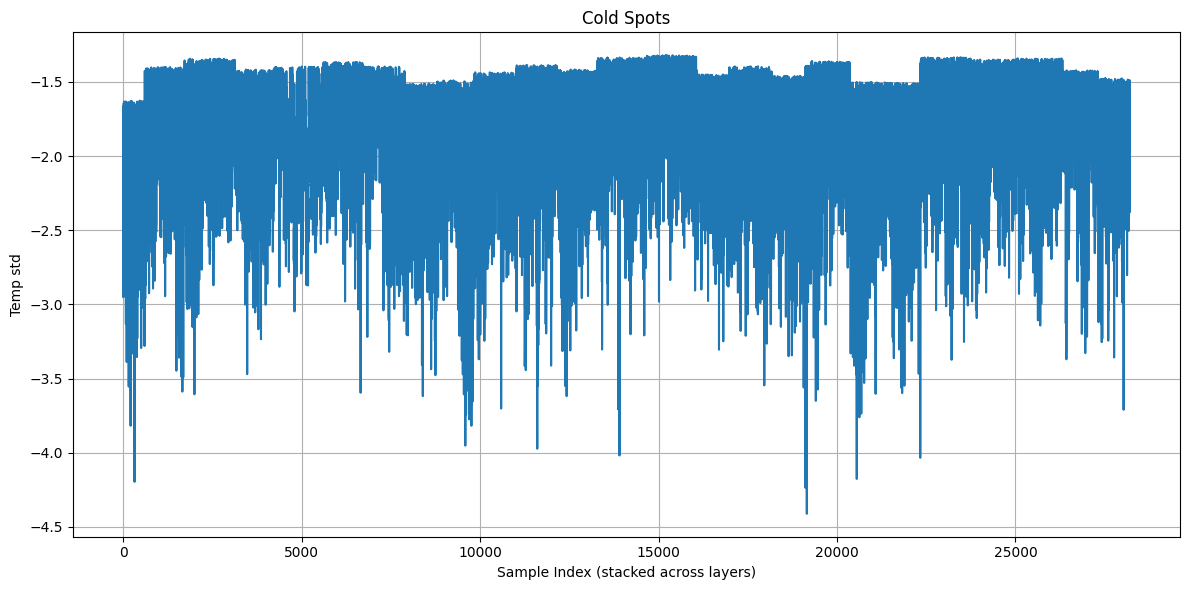

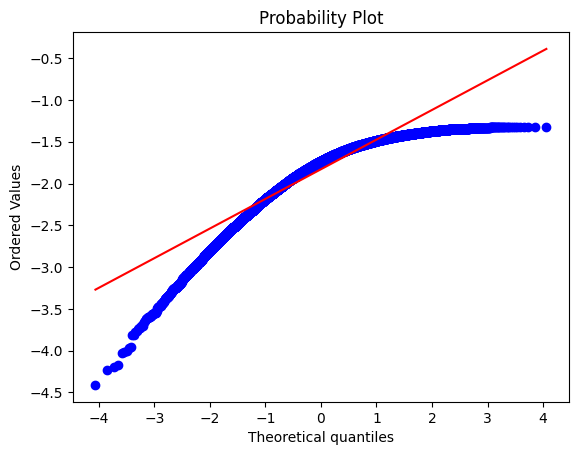

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.415
Runs test p-value = 0.000



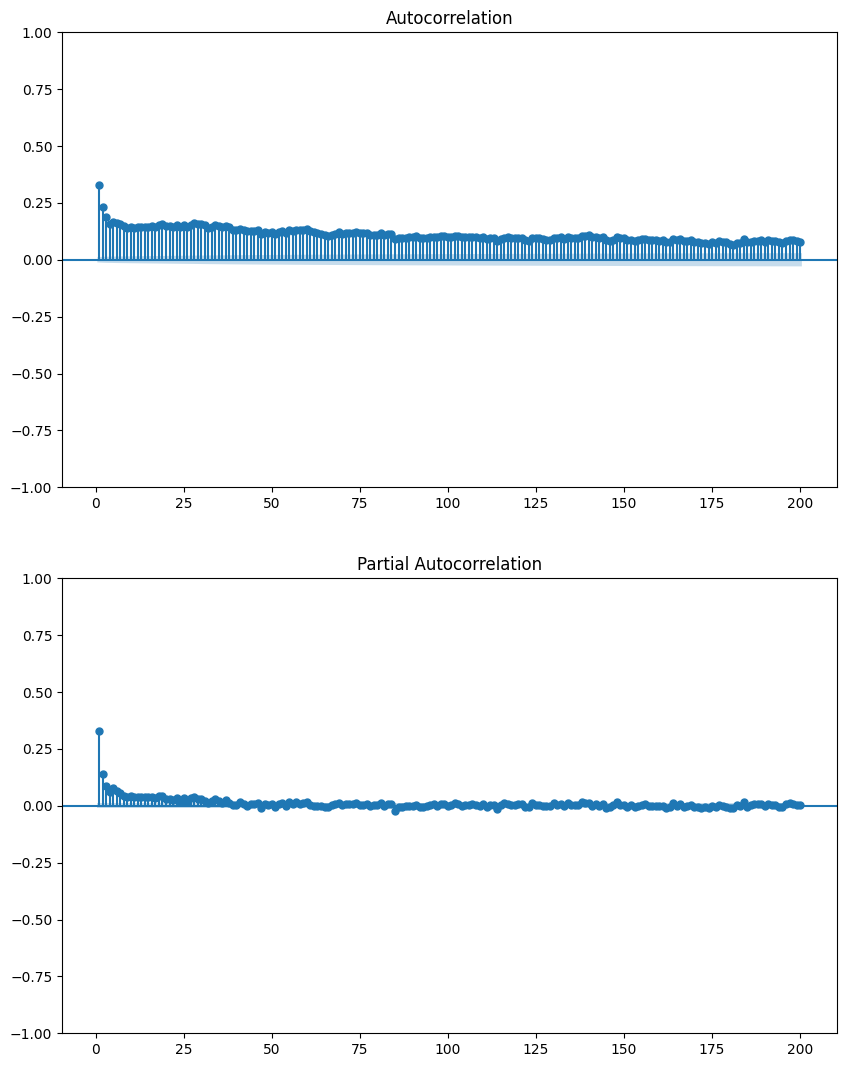

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

In [13]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['layer_id'], cmap='tab20b', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cold Spots by Layer')
cbar = plt.colorbar(scatter, ticks=range(1, 26))
cbar.set_label('Layer ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'cold_spots' is not defined

<Figure size 1000x800 with 0 Axes>

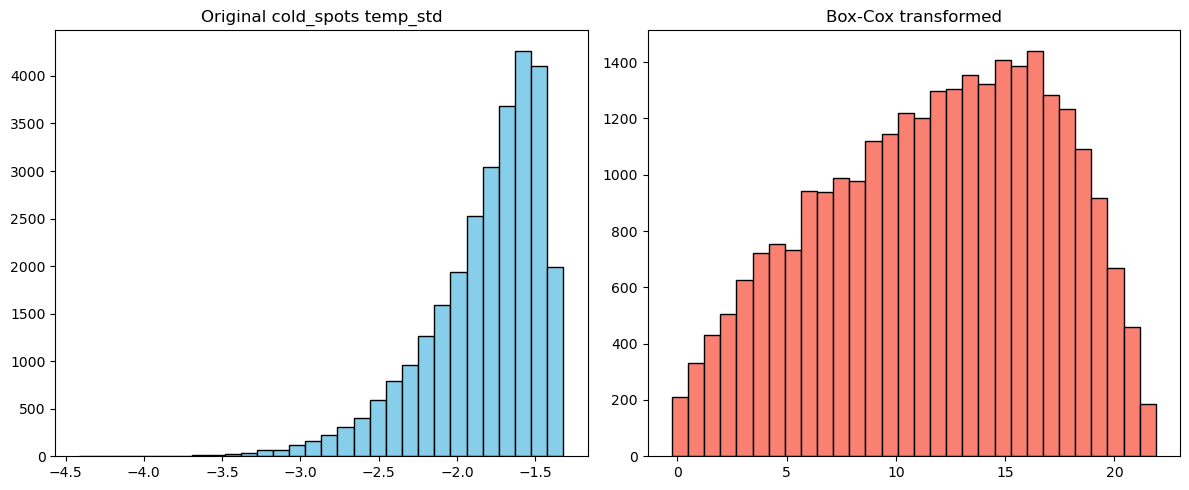

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


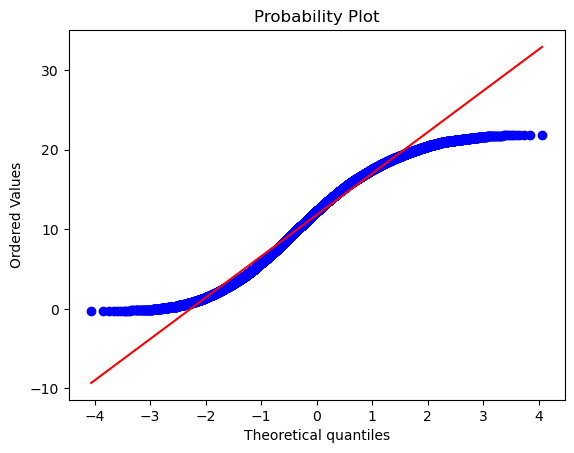

Shapiro-wilk test statistic = 0.973
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
from scipy.stats import boxcox, normaltest

# Box-Cox requires values > 0, so we shift the data
min_val_cs = cold_spots['temp_std'].min()
if min_val_cs <= 0:
    shift = abs(min_val_cs) + 1e-6
else:
    shift = 0

temp_shifted_cs = cold_spots['temp_std'] + shift
temp_boxcox_cs, fitted_lambda_cs = boxcox(temp_shifted_cs)
cold_spots['temp_boxcox_cs'] = temp_boxcox_cs

# Comparison plot: before and after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(cold_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original cold_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_cs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_cs).normality()  

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === Feature Engineering ===
cold_spots['x2'] = cold_spots['x'] ** 2
cold_spots['y2'] = cold_spots['y'] ** 2
cold_spots['xy'] = cold_spots['x'] * cold_spots['y']

features = ['x', 'y', 'x2', 'y2', 'xy']
X_cs = cold_spots[features].values
y_cs = cold_spots['temp_boxcox_cs'].values

# === Train/Test Split ===
X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(X_cs, y_cs, test_size=0.2, random_state=42)

# === Grid Search with Cross-Validation ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'auto']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_cs, y_train_cs)

# === Best model and params ===
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# === Evaluation ===
def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

# Predict
y_train_pred = best_model.predict(X_train_cs)
y_test_pred = best_model.predict(X_test_cs)

print_metrics(y_train_cs, y_train_pred, "Train set")
print_metrics(y_test_cs, y_test_pred, "Test set")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt/

Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train set MSE=25.8797, RMSE=5.0872, MAE=4.2744, R^2=0.0650
Test set MSE=26.8416, RMSE=5.1809, MAE=4.3517, R^2=0.0487


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


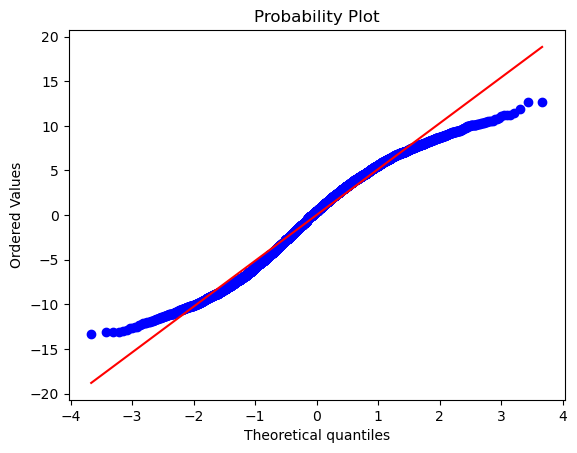

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.981
Shapiro-wilk test p-value = 0.000
Runs test statistic = 0.477
Runs test p-value = 0.633



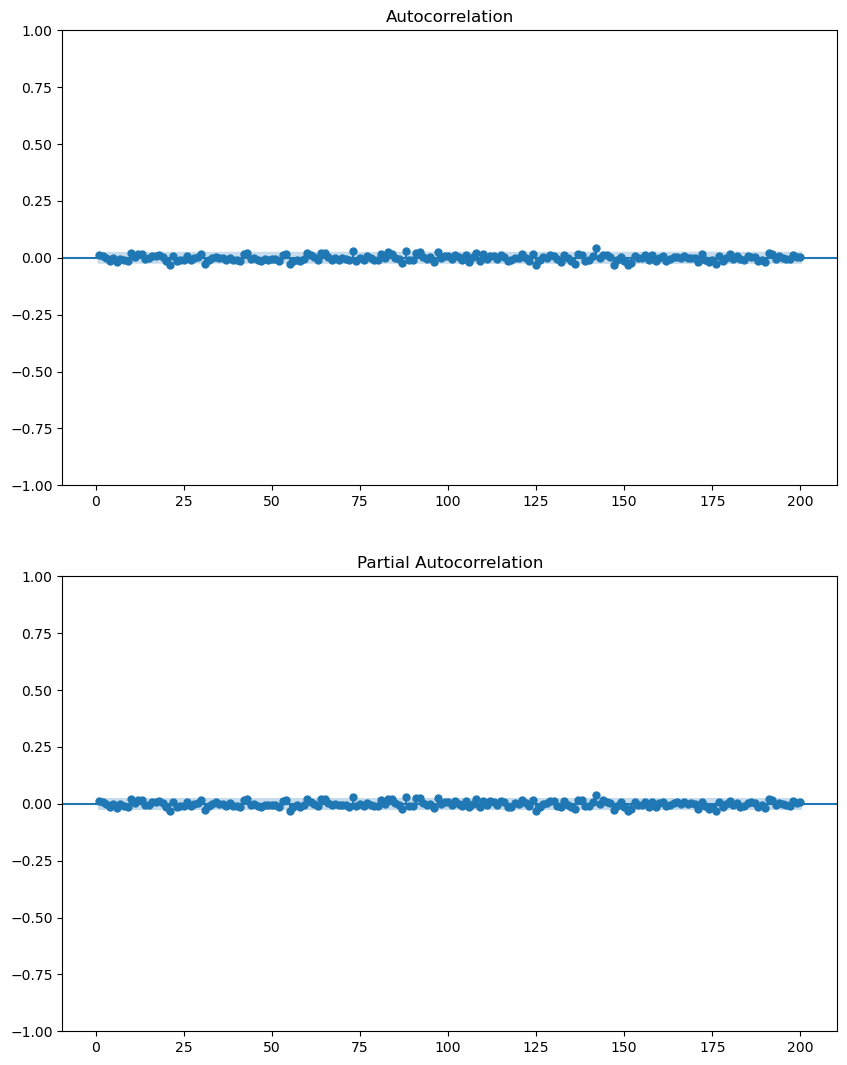

In [60]:
residuals_cs = y_test_cs - y_test_pred
_=qda.Assumptions(residuals_cs).normality() 
_=qda.Assumptions(residuals_cs).independence()  

In [61]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result_cs = anderson(residuals_cs, dist='norm')

print("Anderson-Darling Test Statistic:", result_cs.statistic)
print("Critical Values:", result_cs.critical_values)
print("Significance Levels:", result_cs.significance_level)

# Results interpretation
for i in range(len(result_cs.critical_values)):
    sl, cv = result_cs.significance_level[i], result_cs.critical_values[i]
    if result_cs.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 29.324248871871532
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


In [62]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test
dw_stat_cs = durbin_watson(residuals_cs)
print(f"Durbin-Watson statistic: {dw_stat_cs}")

Durbin-Watson statistic: 1.9783906544407885


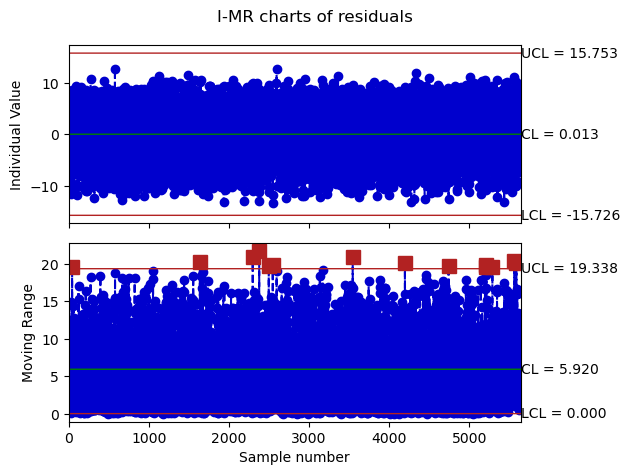

In [63]:
# DataFrame for the residuals
df_SCC_cs = pd.DataFrame(residuals_cs, columns=['residuals'])

# I-MR control chart
df_SCC_IMR_cs = qda.ControlCharts.IMR(df_SCC_cs, 'residuals')

In [64]:
# Out of control points in the I chart
out_of_control_I = ((df_SCC_IMR_cs['residuals'] > df_SCC_IMR_cs['I_UCL']) | (df_SCC_IMR_cs['residuals'] < df_SCC_IMR_cs['I_LCL'])).sum()

# Out of control points in the MR chart
out_of_control_MR = ((df_SCC_IMR_cs['MR'] > df_SCC_IMR_cs['MR_UCL']) | (df_SCC_IMR_cs['MR'] < df_SCC_IMR_cs['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR}")

Punti fuori controllo nella carta I: 0
Punti fuori controllo nella carta MR: 14


## Hot spots

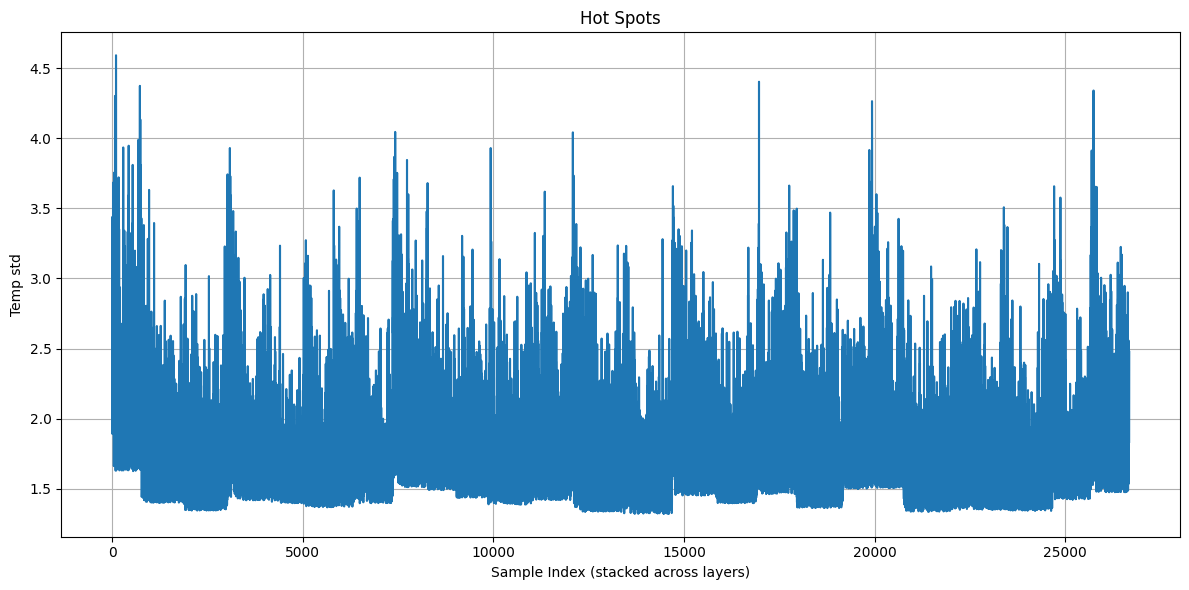

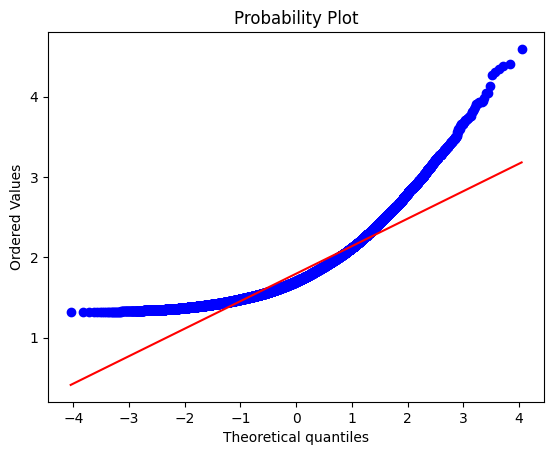

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.870
Shapiro-wilk test p-value = 0.000
Runs test statistic = -28.347
Runs test p-value = 0.000



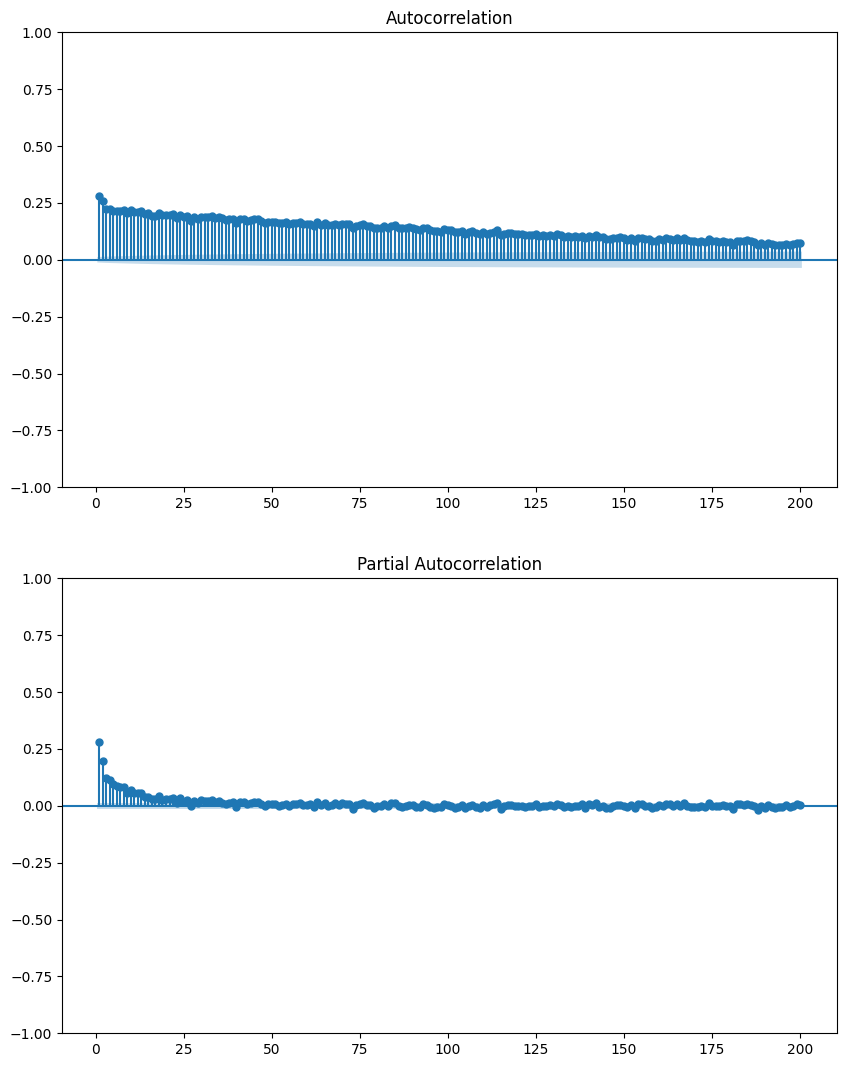

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(hot_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Hot Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(hot_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(hot_spots['temp_std']).independence()  # Controllo di indipendenza

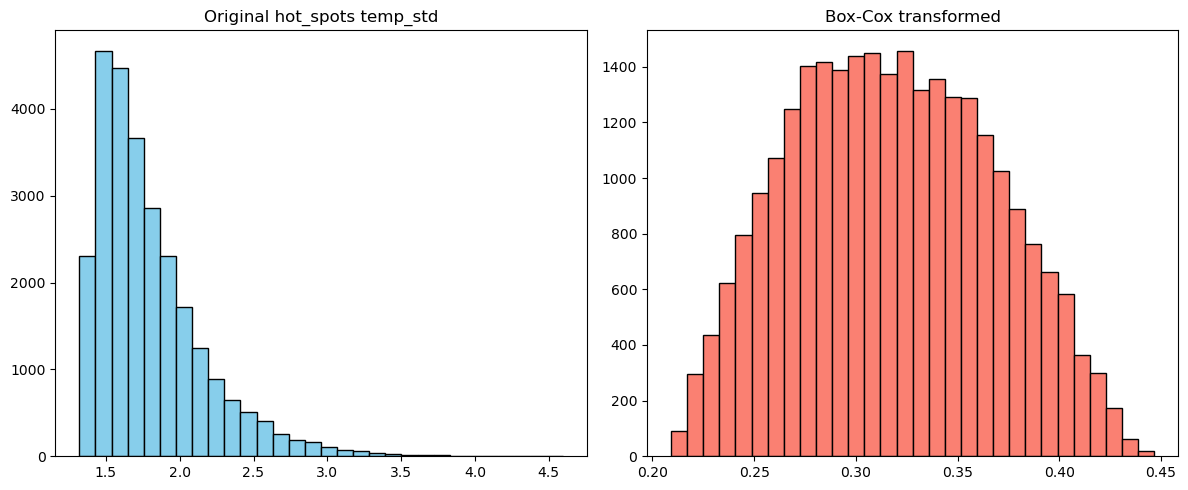

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


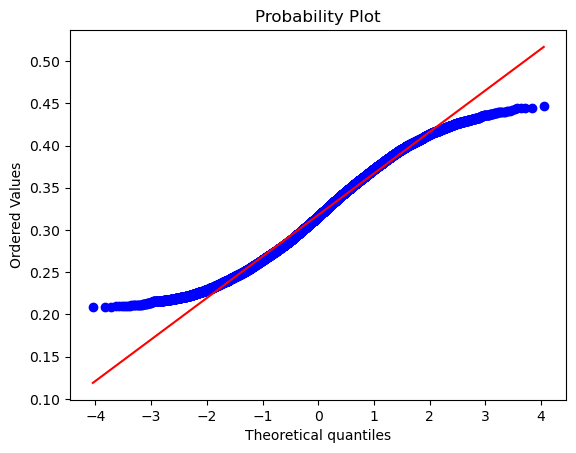

Shapiro-wilk test statistic = 0.986
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [35]:
# Box-Cox requires values > 0, so we shift the data
min_val_hs = hot_spots['temp_std'].min()
if min_val_hs <= 0:
    shift = abs(min_val_hs) + 1e-6
else:
    shift = 0

temp_shifted_hs = hot_spots['temp_std'] + shift
temp_boxcox_hs, fitted_lambda_hs = boxcox(temp_shifted_hs)
hot_spots['temp_boxcox_hs'] = temp_boxcox_hs

# Comparison plot: before and after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(hot_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original hot_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_hs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_hs).normality() 

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === Feature Engineering ===
hot_spots['x2'] = hot_spots['x'] ** 2
hot_spots['y2'] = hot_spots['y'] ** 2
hot_spots['xy'] = hot_spots['x'] * hot_spots['y']

features = ['x', 'y', 'x2', 'y2', 'xy']
X_hs = hot_spots[features].values
y_hs = hot_spots['temp_boxcox_hs'].values

# === Train/Test Split ===
X_train_hs, X_test_hs, y_train_hs, y_test_hs = train_test_split(X_hs, y_hs, test_size=0.2, random_state=42)

# === Grid Search with Cross-Validation ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'auto']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_hs, y_train_hs)

# === Best model and params ===
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# === Evaluation ===
def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

# Predict
y_train_pred = best_model.predict(X_train_hs)
y_test_pred = best_model.predict(X_test_hs)

print_metrics(y_train_hs, y_train_pred, "Train set")
print_metrics(y_test_hs, y_test_pred, "Test set")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
111 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt

Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Train set MSE=0.0022, RMSE=0.0467, MAE=0.0389, R^2=0.1069
Test set MSE=0.0022, RMSE=0.0473, MAE=0.0395, R^2=0.0934


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


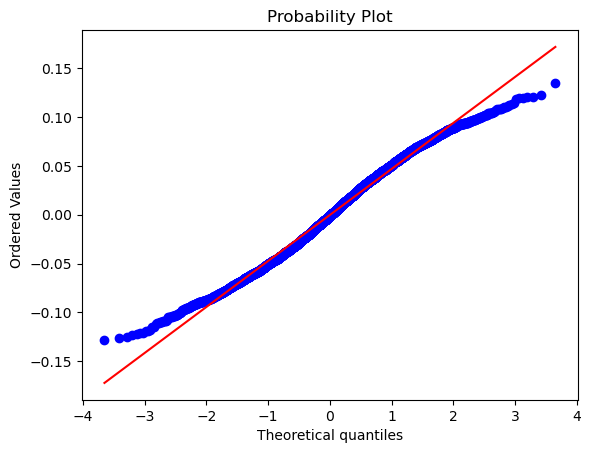

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.991
Shapiro-wilk test p-value = 0.000
Runs test statistic = 0.100
Runs test p-value = 0.921



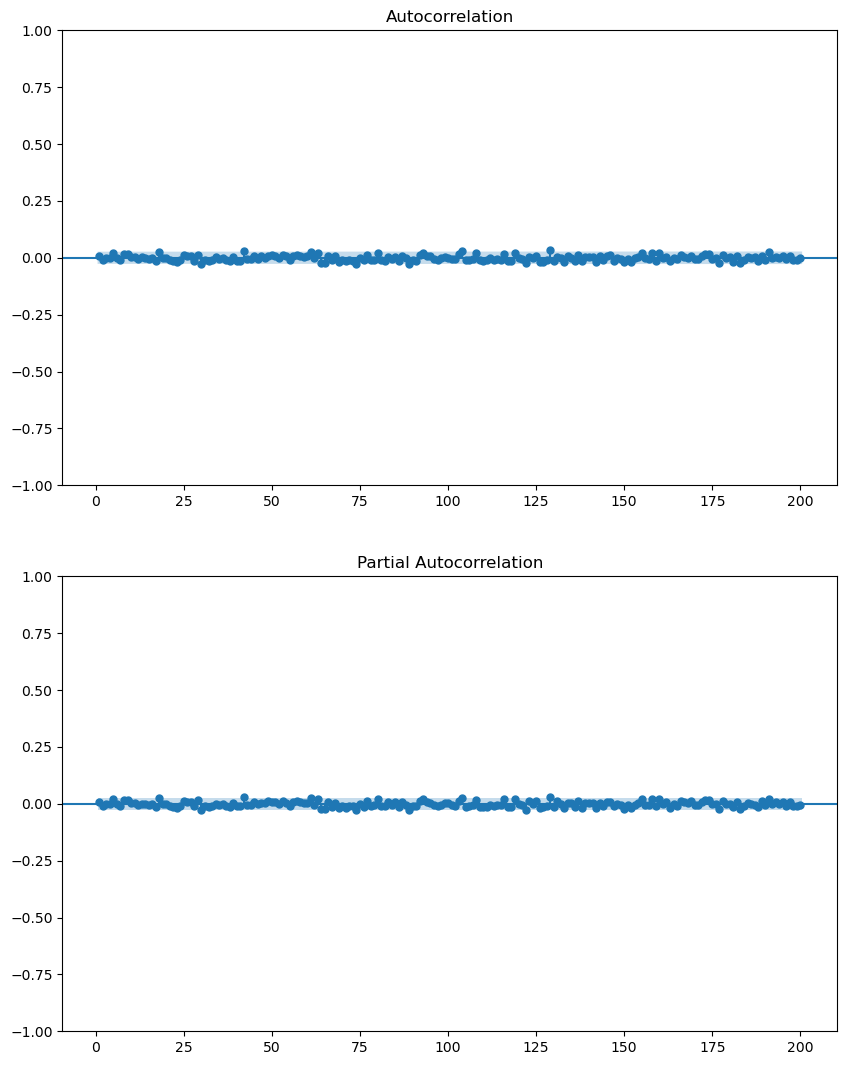

In [66]:

residuals_hs = y_test_hs - y_test_pred
_=qda.Assumptions(residuals_hs).normality() 
_=qda.Assumptions(residuals_hs).independence()  

In [67]:
# Anderson-Darling test for normality
result_hs = anderson(residuals_hs, dist='norm')

print("Anderson-Darling Test Statistic:", result_hs.statistic)
print("Critical Values:", result_hs.critical_values)
print("Significance Levels:", result_hs.significance_level)

for i in range(len(result_hs.critical_values)):
    sl_hs, cv_hs = result_hs.significance_level[i], result_hs.critical_values[i]
    if result_hs.statistic < cv_hs:
        print(f"At {sl_hs}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl_hs}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 13.209284142154502
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


In [68]:
# Durbin-Watson test for autocorrelation
dw_stat_hs = durbin_watson(residuals_hs)
print(f"Durbin-Watson statistic: {dw_stat_hs}")

Durbin-Watson statistic: 1.988081658823674


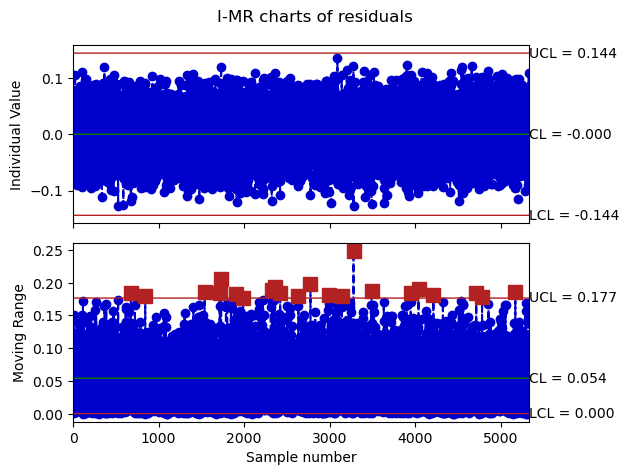

In [69]:
# DataFrame for the residuals
df_SCC_hs = pd.DataFrame(residuals_hs, columns=['residuals'])

# I-MR control chart
df_SCC_IMR_hs = qda.ControlCharts.IMR(df_SCC_hs, 'residuals')

In [70]:
# Out of control points in the I chart
out_of_control_I_hs = ((df_SCC_IMR_hs['residuals'] > df_SCC_IMR_hs['I_UCL']) | (df_SCC_IMR_hs['residuals'] < df_SCC_IMR_hs['I_LCL'])).sum()

# Out of control points in the MR chart
out_of_control_MR_hs = ((df_SCC_IMR_hs['MR'] > df_SCC_IMR_hs['MR_UCL']) | (df_SCC_IMR_hs['MR'] < df_SCC_IMR_hs['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I_hs}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR_hs}")

Punti fuori controllo nella carta I: 0
Punti fuori controllo nella carta MR: 22


## Regular Points

In [7]:
# Iterate through each layer's biggest cluster data
regular_data_list = []
for layer_data in biggest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        regular_data_list.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
regular_data = pd.DataFrame(regular_data_list)
regular_data.head()

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,3,0,0.606690,1
2,5,0,0.475641,1
3,9,0,1.329965,1
4,11,0,0.945900,1


In [8]:
# Batch the regular_data DataFrame by keeping 1 row every 5
generate_temperature_matrices_v1_size = 5
gapped_data = regular_data.iloc[::5].reset_index(drop=True)
gapped_data.head() 

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,13,0,0.973318,1
2,25,0,-0.714688,1
3,34,0,1.174879,1
4,41,0,0.929085,1


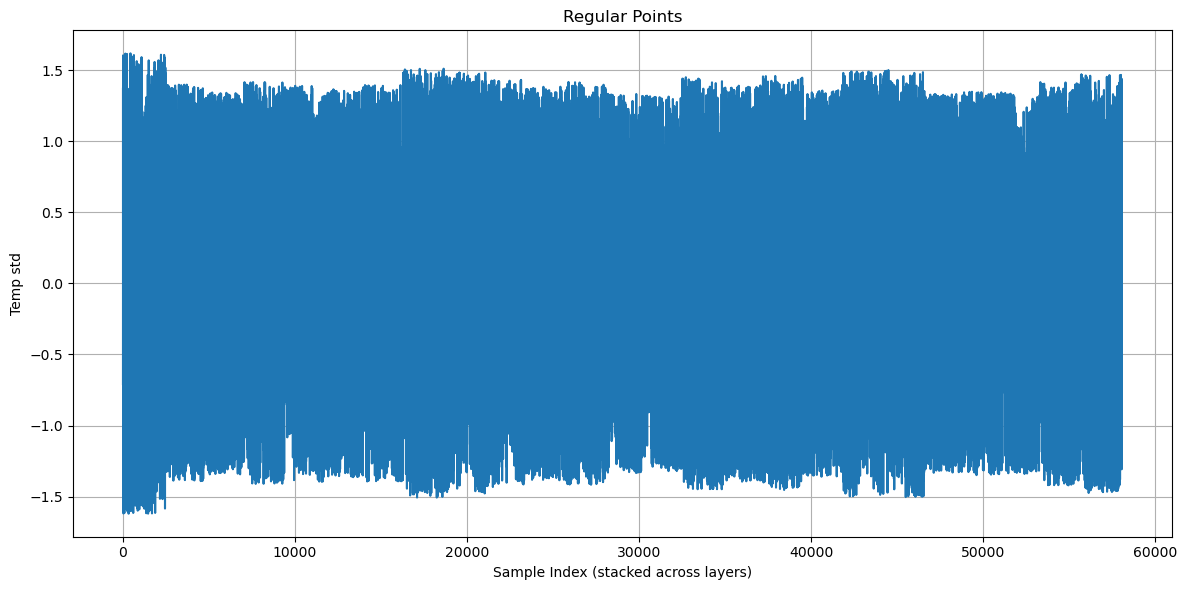

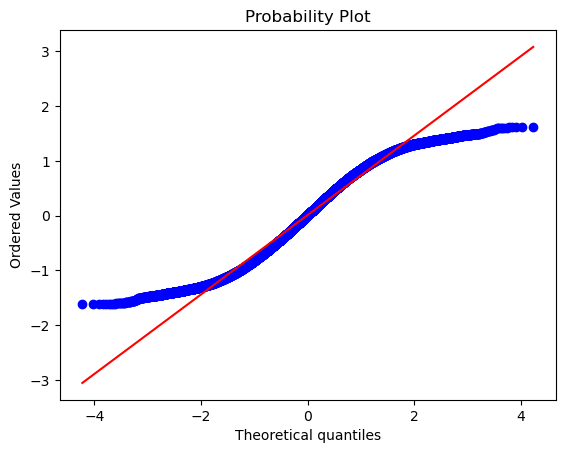

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.976
Shapiro-wilk test p-value = 0.000
Runs test statistic = -37.681
Runs test p-value = 0.000



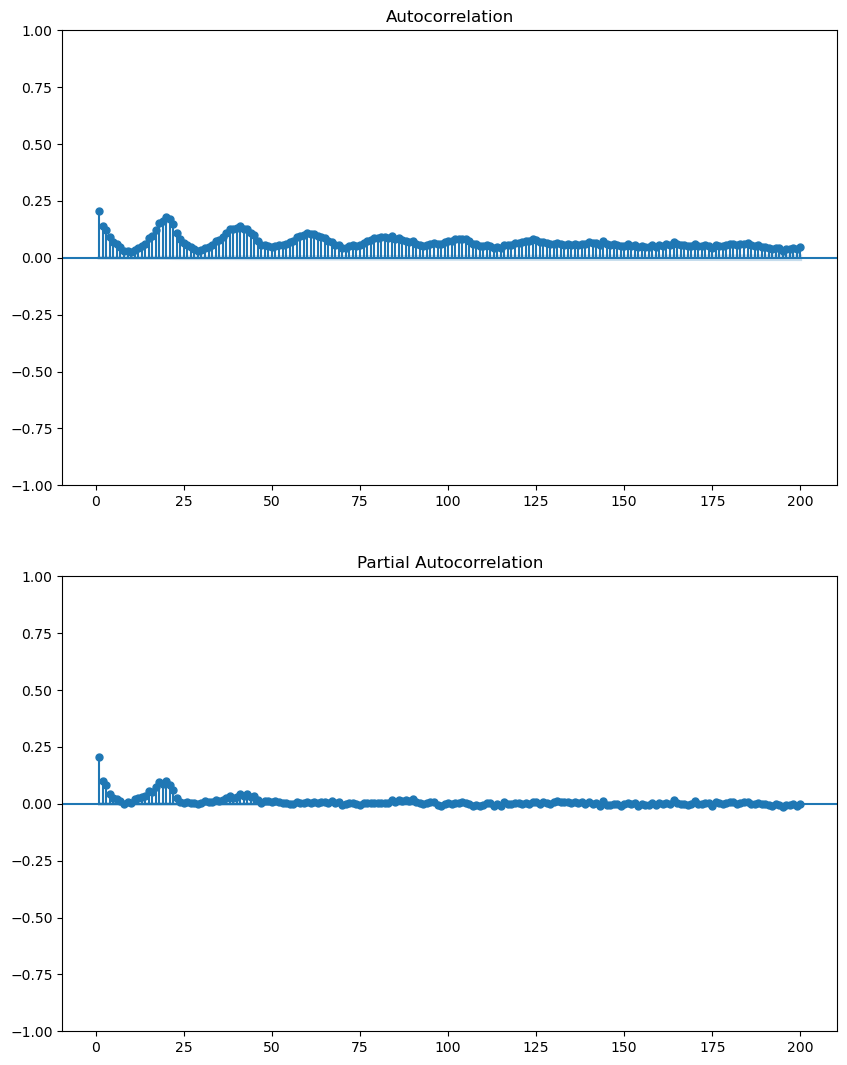

In [44]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(gapped_data['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Regular Points')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(gapped_data['temp_std']).normality()
_ = qda.Assumptions(gapped_data['temp_std']).independence()  

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === Feature Engineering ===
gapped_data['x2'] = gapped_data['x'] ** 2
gapped_data['y2'] = gapped_data['y'] ** 2
gapped_data['xy'] = gapped_data['x'] * gapped_data['y']

features = ['x', 'y', 'x2', 'y2', 'xy']
X = gapped_data[features].values
y = gapped_data['temp_std'].values

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Grid Search with Cross-Validation ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'auto']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# === Best model and params ===
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# === Evaluation ===
def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print_metrics(y_train, y_train_pred, "Train set")
print_metrics(y_test, y_test_pred, "Test set")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/qda/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt/

Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train set MSE=0.5198, RMSE=0.7210, MAE=0.6084, R^2=0.0355
Test set MSE=0.5300, RMSE=0.7280, MAE=0.6160, R^2=0.0212


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


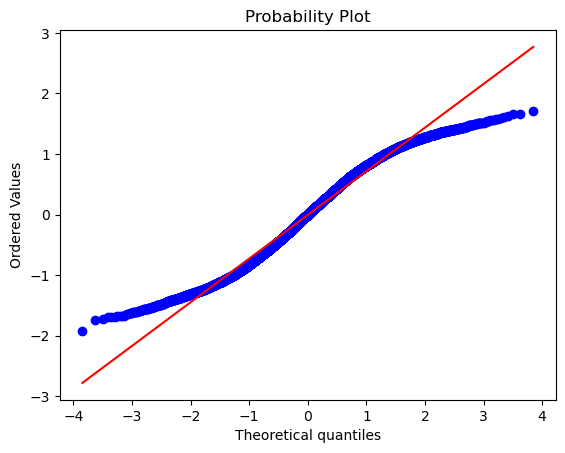

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.980
Shapiro-wilk test p-value = 0.000
Runs test statistic = -1.616
Runs test p-value = 0.106



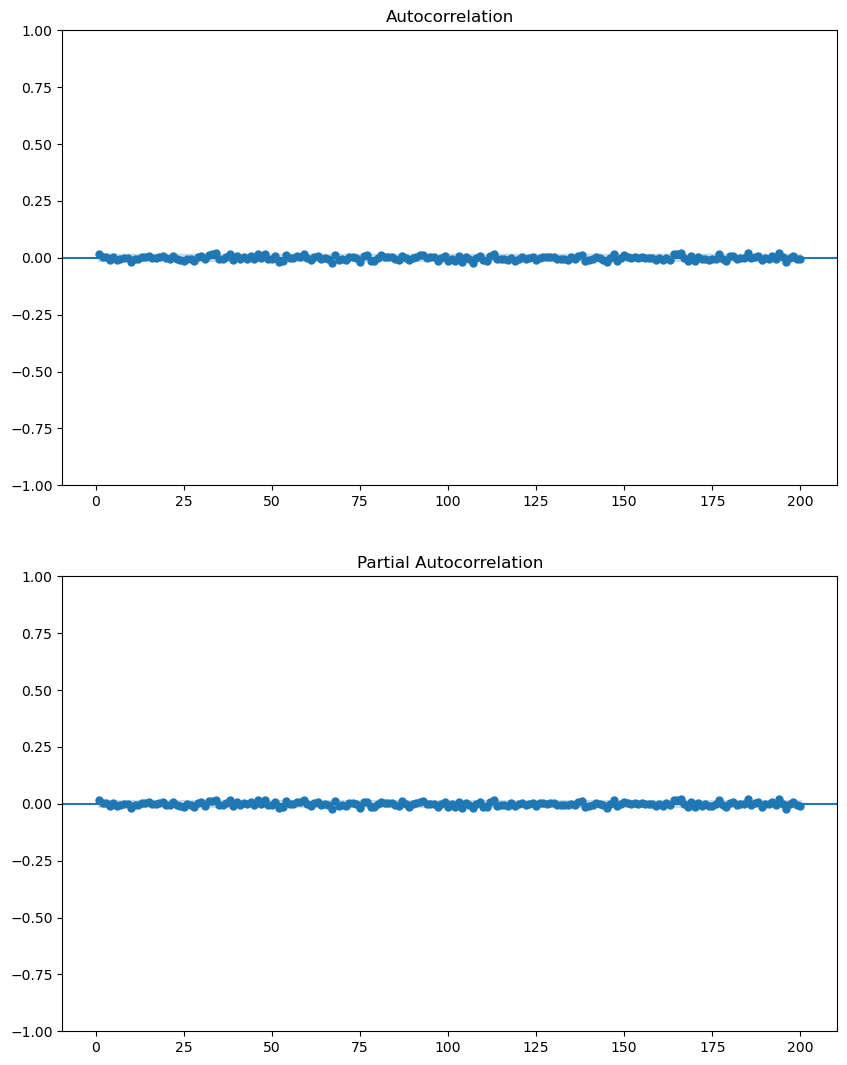

In [10]:
residuals = y_test - y_test_pred
_=qda.Assumptions(residuals).normality()  # Controllo di normalità
_=qda.Assumptions(residuals).independence()  # Controllo di indipendenza

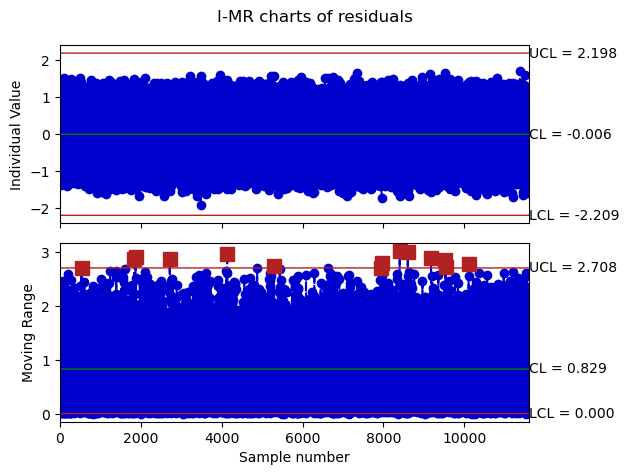

In [11]:
# DataFrame for the residuals
df_SCC = pd.DataFrame(residuals, columns=['residuals'])

# I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'residuals')

In [12]:
# Out of control points in the I chart
out_of_control_I = ((df_SCC_IMR['residuals'] > df_SCC_IMR['I_UCL']) | (df_SCC_IMR['residuals'] < df_SCC_IMR['I_LCL'])).sum()

# Out of control points in the MR chart
out_of_control_MR = ((df_SCC_IMR['MR'] > df_SCC_IMR['MR_UCL']) | (df_SCC_IMR['MR'] < df_SCC_IMR['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR}")

Punti fuori controllo nella carta I: 0
Punti fuori controllo nella carta MR: 14


In [166]:
len(residuals)
print(len(residuals))

11611
